In [40]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Table for data entries and abbreviations

#### Batting Data: G AB R H 2B 3B HR RBI BB IBB SO HBP SH SF XI ROE GDP SB CS AVG OBP SLG HAND

0: G: Games, total game played <br/>
1: AB: At bat, Total times at bat <br/>
2: R: Runs, total runs scored <br/>
3: H: Hits, total fair play hits <br/>
4: 2B: Double, reaching 2nd base from batting <br/>
5: 3B: Triple, reaching 3rd base from batting <br/>
6: HR: Home run, scoring straight from batting (includes in field home runs) <br/>
7: RBI: Runs batted in, total runs from this player's at bat <br/>
8: BB: Walks, total times walked (includes intentional walks) <br/>
9: IBB: Intentional Walk, intentionally walking batter to first base <br/>
10: SO: Strike out, total times struck out at base <br/>
11: HBP: Hit by pitch, total times <br/>
12: SH: Sacrifice bunt, bunt resulting in the batter being out but advances another runner <br/>
13: SF: Sacrifice fly, fly ball resulting in the batter being out but advances another runner <br/>
14: XI: ?, (almost all players have 0 for this statistic) <br/>
15: ROE: Reached on error, total times on base due to an error <br/>
16: GDP: Grounded into double play <br/>
17: SB: Stolen base, total bases stolen <br/>
18: CS: Caught stealing, Total times getting out when stealing.<br/>
19: AVG: Batting average, (total hits / total at bats) <br/>
20: OBP: On base percentage, (total times on base / total at bats) <br/>
21: SLG: Slugging percentage, bases per at bat ((1B + 2*2B + 3*3B + 4*HR) / AB) <br/>
22: HAND: Handedness, batting hand (1 = right, -1 = left) <br/>



#### Pitching Data: G GS CG SHO GF SV IP H BFP HR R ER BB IB SO SH SF WP HBP BK 2B 3B GDP ROE W L ERA RS PW HAND

0: G: Games played, total games played <br/>
1: GS: Games Started, threw the first pitch <br/>
2: CG: Complete game, pitched for the entire game <br/>
3: SHO: Shutout, pitches entire game without opposition scoring <br/>
4: GF: Games Finished, threw the last pitch (not counted if there was only 1 pitcher for the game) <br/>
5: SV: save, relief pitcher resulting in a win under certain conditions, https://www.mlb.com/glossary/standard-stats/save <br/>
6: IP: Innings pitched, total innings pitched (can be partial) <br/>
7: H: Hits, total hits allowed <br/>
8: BFP: Total batters face, total batters at plate when pitching <br/>
9: HR: Home runs allowed <br/>
10: R: Runs allowed?, total runs allowed <br/>
11: ER: Earned Run, total runs scored by the opposition due to the pitcher <br/>
12: BB: Walk, total walks <br/>
13: IB: Intentional walk? <br/>
14: SO: Strikeout, total batters struck out <br/>
15: SH: Sacrifice bunt, bunt resulting in the batter being out but advances another runner <br/>
16: SF: Sacrifice fly, fly ball resulting in the batter being out but advances another runner <br/>
17: WP: Wild pitches, pitch out of range for the catcher causing a runner to advance <br/>
18: HBP: Hit by pitch?, times batter is hit by a pitch <br/>
19: BK: Balk, number of illegal actions <br/>
20: 2B: Doubles allowed <br/>
21: 3B: Triples allowed <br/>
22: GDP: Grounded double plays? <br/>
23: ROE: Reached on error?, number of batters on base due to an error <br/>
24: W: Win, pitched while their team took the team and won the game <br/>
25: L: Loss, pitched while their team lost the lead and lost the game <br/>
26: ERA: Earned run average, (allowed runs * 9 / innings pitched ) <br/>
27: RS: Run support?, average opposition score (per game, not per inning) <br/>
28: PW: Total player rating, linear weighting of multiple statistics, https://en.wikipedia.org/wiki/Total_player_rating <br/>
29: HAND: Handedness, Pitching hand (1 = right, -1 = left) <br/>

In [15]:
def getDataFromFile(fileName, pitchingDataList, battingDataList):
    fileData=np.loadtxt(fileName, delimiter=',') 
    [N,dim]=np.shape(fileData) #set up matrix from file
    
    fileX = np.zeros((N, dim))
    dataY = np.zeros((N))
    
    fileX = fileData[:, 0:dim - 1] #remove output from the x array
    dataY[:] = fileData[:, dim - 1]
    
    dataX = np.zeros((N, 2*len(pitchingDataList) + 18*len(battingDataList)))
    dataXIndex = 0
    for i in pitchingDataList: #add data for home pitcher
        dataX[:,dataXIndex] = fileX[:,i]
        dataXIndex = dataXIndex + 1
    for i in range(9): #add data for home batters
        for j in battingDataList:
            dataX[:,dataXIndex] = fileX[:,(30 + 23*i + j)]
            dataXIndex = dataXIndex + 1
    for i in pitchingDataList: #add data for away pitcher
        dataX[:,dataXIndex] = fileX[:,(30 + 23*9 + i)]
        dataXIndex = dataXIndex + 1
    for i in range(9): #add data for away batters
        for j in battingDataList:
            dataX[:,dataXIndex] = fileX[:,(2*30 + 23*(9+i) + j)]
            dataXIndex = dataXIndex + 1
    
    return dataX, dataY

In [51]:
def getMeanAndStd(data): #get the mean and standard deviation of data columns
    means = [] #mean for each column
    stds = [] #standard deviation for each column
    for i in range(np.shape(data)[1]):
        mean = sum(data[:,i]) / len(data) 
        means.append(mean)
        stds.append( np.sqrt( sum((mean - data[:,i])**2)/len(data)) )
    return means, stds

def applyMeanAndStd(data, means, stds):
    newData = data
    for i in range(np.shape(newData)[1]):
        newData[:,i] = (data[:,i] - means[i])/stds[i] #normalize so that mean = 0, std = 1
    return newData

In [56]:
def runModel(trainX, trainY, testX, testY, model, epochCount): #run and graph model results
    #compile the model
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    historyData = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=epochCount, verbose = 1)
    eIn = historyData.history["accuracy"]
    eOut = historyData.history["val_accuracy"]
    
    for i in range(len(eIn)):
        eIn[i] = 1-eIn[i]
    for i in range(len(eOut)):
        eOut[i] = 1-eOut[i]

    print('Train error:', eIn[-1])
    print('Test error: ', eOut[-1])
    
    #return error data to be plot later
    return eIn, eOut

In [59]:
trainFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\train.txt"
valFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\val.txt"
#testFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\test.txt"

batDataList = [19, 20, 21, 17, 22] #on base %, hit %, slug %, bases stolen, hand
#batDataList = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
pitDataList = [26, 29] #era, hand
#pitDataList = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

trainX, trainY = getDataFromFile(trainFileName, pitDataList, batDataList)
valX, valY = getDataFromFile(valFileName, pitDataList, batDataList)
#testX, testY = getDataFromFile(testFileName)#

In [60]:
dataMeans, dataStds = getMeanAndStd(trainX)
trainX = applyMeanAndStd(trainX, dataMeans, dataStds)
valX = applyMeanAndStd(valX, dataMeans, dataStds)

Epoch 1/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.7139 - accuracy: 0.5392 - val_loss: 0.6920 - val_accuracy: 0.5311
Epoch 2/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6843 - accuracy: 0.5598 - val_loss: 0.6837 - val_accuracy: 0.5649
Epoch 3/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6849 - accuracy: 0.5569 - val_loss: 0.6883 - val_accuracy: 0.5526
Epoch 4/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6836 - accuracy: 0.5629 - val_loss: 0.6860 - val_accuracy: 0.5487
Epoch 5/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6831 - accuracy: 0.5594 - val_loss: 0.6859 - val_accuracy: 0.5487
Epoch 6/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6828 - accuracy: 0.5650 - val_loss: 0.6822 - val_accuracy: 0.5638
Epoch 7/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6837 - accuracy: 0.5610 - val_loss: 0.6827 -

Epoch 57/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6807 - accuracy: 0.5690 - val_loss: 0.6820 - val_accuracy: 0.5619
Epoch 58/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6813 - accuracy: 0.5680 - val_loss: 0.6818 - val_accuracy: 0.5608
Epoch 59/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6795 - accuracy: 0.5732 - val_loss: 0.6821 - val_accuracy: 0.5610
Epoch 60/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6786 - accuracy: 0.5736 - val_loss: 0.6825 - val_accuracy: 0.5617
Epoch 61/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6804 - accuracy: 0.5699 - val_loss: 0.6817 - val_accuracy: 0.5598
Epoch 62/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6797 - accuracy: 0.5717 - val_loss: 0.6818 - val_accuracy: 0.5608
Epoch 63/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6794 - accuracy: 0.5712 - val_loss: 0

1018/1018 [==============================] - 2s 2ms/step - loss: 0.6794 - accuracy: 0.5748 - val_loss: 0.6821 - val_accuracy: 0.5609
Epoch 168/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6818 - accuracy: 0.5665 - val_loss: 0.6826 - val_accuracy: 0.5625
Epoch 169/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6787 - accuracy: 0.5714 - val_loss: 0.6817 - val_accuracy: 0.5610
Epoch 170/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6802 - accuracy: 0.5725 - val_loss: 0.6817 - val_accuracy: 0.5611
Epoch 171/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6793 - accuracy: 0.5703 - val_loss: 0.6819 - val_accuracy: 0.5616
Epoch 172/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6785 - accuracy: 0.5736 - val_loss: 0.6823 - val_accuracy: 0.5606
Epoch 173/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6788 - accuracy: 0.5743 - val_loss: 0.6821 - 

1018/1018 [==============================] - 2s 2ms/step - loss: 0.6791 - accuracy: 0.5725 - val_loss: 0.6819 - val_accuracy: 0.5609
Epoch 278/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6800 - accuracy: 0.5734 - val_loss: 0.6836 - val_accuracy: 0.5616
Epoch 279/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6797 - accuracy: 0.5718 - val_loss: 0.6821 - val_accuracy: 0.5612
Epoch 280/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6784 - accuracy: 0.5742 - val_loss: 0.6828 - val_accuracy: 0.5614
Epoch 281/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6781 - accuracy: 0.5748 - val_loss: 0.6862 - val_accuracy: 0.5634
Epoch 282/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6795 - accuracy: 0.5747 - val_loss: 0.6824 - val_accuracy: 0.5614
Epoch 283/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6784 - accuracy: 0.5742 - val_loss: 0.6822 - 

1018/1018 [==============================] - 2s 2ms/step - loss: 0.6785 - accuracy: 0.5761 - val_loss: 0.6819 - val_accuracy: 0.5614
Epoch 333/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6782 - accuracy: 0.5727 - val_loss: 0.6818 - val_accuracy: 0.5610
Epoch 334/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6800 - accuracy: 0.5705 - val_loss: 0.6818 - val_accuracy: 0.5619
Epoch 335/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6782 - accuracy: 0.5774 - val_loss: 0.6818 - val_accuracy: 0.5624780 - ac
Epoch 336/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6810 - accuracy: 0.5725 - val_loss: 0.6818 - val_accuracy: 0.5615
Epoch 337/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6800 - accuracy: 0.5728 - val_loss: 0.6818 - val_accuracy: 0.5610
Epoch 338/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5755 - val_loss: 0

1018/1018 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5741 - val_loss: 0.6819 - val_accuracy: 0.5595
Epoch 443/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6812 - accuracy: 0.5677 - val_loss: 0.6826 - val_accuracy: 0.5617
Epoch 444/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6787 - accuracy: 0.5734 - val_loss: 0.6819 - val_accuracy: 0.5617
Epoch 445/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5725 - val_loss: 0.6821 - val_accuracy: 0.5611
Epoch 446/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6789 - accuracy: 0.5725 - val_loss: 0.6842 - val_accuracy: 0.5609
Epoch 447/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6804 - accuracy: 0.5743 - val_loss: 0.6822 - val_accuracy: 0.5631
Epoch 448/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6807 - accuracy: 0.5746 - val_loss: 0.6819 - 

1018/1018 [==============================] - 2s 2ms/step - loss: 0.6795 - accuracy: 0.5748 - val_loss: 0.6819 - val_accuracy: 0.5614
Epoch 553/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5688 - val_loss: 0.6823 - val_accuracy: 0.5615
Epoch 554/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5701 - val_loss: 0.6821 - val_accuracy: 0.5601
Epoch 555/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6785 - accuracy: 0.5729 - val_loss: 0.6818 - val_accuracy: 0.5616
Epoch 556/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6781 - accuracy: 0.5716 - val_loss: 0.6818 - val_accuracy: 0.5621
Epoch 557/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6792 - accuracy: 0.5726 - val_loss: 0.6819 - val_accuracy: 0.5617
Epoch 558/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6786 - accuracy: 0.5755 - val_loss: 0.6823 - 

1018/1018 [==============================] - 2s 2ms/step - loss: 0.6788 - accuracy: 0.5775 - val_loss: 0.6820 - val_accuracy: 0.5629
Epoch 663/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6796 - accuracy: 0.5713 - val_loss: 0.6828 - val_accuracy: 0.5619
Epoch 664/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6802 - accuracy: 0.5680 - val_loss: 0.6821 - val_accuracy: 0.5624
Epoch 665/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6787 - accuracy: 0.5753 - val_loss: 0.6822 - val_accuracy: 0.5615
Epoch 666/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5731 - val_loss: 0.6818 - val_accuracy: 0.5623
Epoch 667/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6780 - accuracy: 0.5713 - val_loss: 0.6827 - val_accuracy: 0.5611
Epoch 668/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6784 - accuracy: 0.5774 - val_loss: 0.6819 - 

1018/1018 [==============================] - 2s 2ms/step - loss: 0.6808 - accuracy: 0.5700 - val_loss: 0.6836 - val_accuracy: 0.5631
Epoch 773/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6793 - accuracy: 0.5715 - val_loss: 0.6821 - val_accuracy: 0.5619
Epoch 774/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6794 - accuracy: 0.5731 - val_loss: 0.6840 - val_accuracy: 0.5641
Epoch 775/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6806 - accuracy: 0.5689 - val_loss: 0.6822 - val_accuracy: 0.5634
Epoch 776/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6779 - accuracy: 0.5748 - val_loss: 0.6825 - val_accuracy: 0.5619 - ETA: 0s - loss: 0.6775 - 
Epoch 777/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6780 - accuracy: 0.5752 - val_loss: 0.6821 - val_accuracy: 0.5590
Epoch 778/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6769 - accuracy: 

Epoch 827/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6796 - accuracy: 0.5765 - val_loss: 0.6822 - val_accuracy: 0.5630
Epoch 828/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6793 - accuracy: 0.5752 - val_loss: 0.6823 - val_accuracy: 0.5624
Epoch 829/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6791 - accuracy: 0.5730 - val_loss: 0.6819 - val_accuracy: 0.5619
Epoch 830/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6800 - accuracy: 0.5735 - val_loss: 0.6827 - val_accuracy: 0.5599
Epoch 831/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6801 - accuracy: 0.5709 - val_loss: 0.6818 - val_accuracy: 0.5639
Epoch 832/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6797 - accuracy: 0.5696 - val_loss: 0.6819 - val_accuracy: 0.5625
Epoch 833/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6801 - accuracy: 0.5703 - val_

1018/1018 [==============================] - 2s 2ms/step - loss: 0.6805 - accuracy: 0.5696 - val_loss: 0.6822 - val_accuracy: 0.5606
Epoch 938/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6808 - accuracy: 0.5712 - val_loss: 0.6822 - val_accuracy: 0.5624
Epoch 939/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5745 - val_loss: 0.6819 - val_accuracy: 0.5624
Epoch 940/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6787 - accuracy: 0.5747 - val_loss: 0.6823 - val_accuracy: 0.5605
Epoch 941/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5755 - val_loss: 0.6818 - val_accuracy: 0.5619
Epoch 942/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6780 - accuracy: 0.5741 - val_loss: 0.6817 - val_accuracy: 0.5640: 0.
Epoch 943/1000
1018/1018 [==============================] - 2s 2ms/step - loss: 0.6787 - accuracy: 0.5724 - val_loss: 0.682

[]

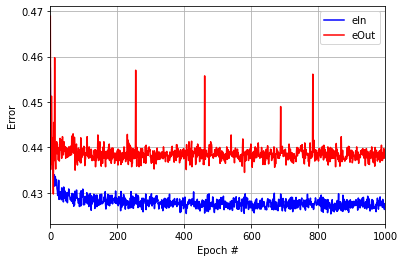

In [69]:
modelInter = tf.keras.Sequential([
        keras.layers.Dense(units=np.shape(trainX)[1], activation='linear'),
        keras.layers.Dense(units=75, activation='linear'),
        keras.layers.Dense(units=75, activation='linear'),
        keras.layers.Dense(units=50, activation='linear'),
        keras.layers.Dense(units=50, activation='linear'),
        keras.layers.Dense(units=25, activation='linear'),
        keras.layers.Dense(units=1, activation='sigmoid')
    ])

epochs = 1000
eIn, eOut = runModel(trainX, trainY, valX, valY, modelInter, epochs)

fig, ax=plt.subplots()
ax.plot(eIn,'-b')
ax.plot(eOut,'-r')
ax.set_xlabel('Epoch #')
ax.set_ylabel('Error')
ax.grid()
ax.legend(['eIn', 'eOut'])
ax.axes.set_xlim([0,epochs])
ax.plot()

In [68]:
1 - eOut[-1]

0.5631250143051147